# Лабораторная работа по курсу "Искуственный интелект":
## "Генерация текстов/последовательностей с помощью нейронных сетей"

Студент группы М8О-307Б-17 Жуков Максим Александрович


## Постановка задачи:
Научиться генерировать последовательности с помощью рекуррентных нейронных сетей.

Вариант 1:

Проза на русском языке, элемент последовательности - один символ. Источник данных - тексты c http://lib.ru


План работы:

1.Код оформить в виде Jupyter-ноутбука с пояснениями по ходу программы.

2.Для каждого задания необходимо исследовать несколько различных нейросетевых архитектур:

        а) Обычная полносвязная RNN

        б) Однослойная LSTM

        в) Двухслойная LSTM

        г) Однослойный GRU

3.Результаты оформить в виде отчета Report.md

In [12]:
from __future__ import print_function
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM, Flatten
from keras.layers import SimpleRNN, Reshape
from keras.layers import GRU, Embedding
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io
import os
import string

# Подготовка текста
Скачиваем текст с https://www.gutenberg.org/ и указываем путь к нему. Также определим общее количество символов в тексте и выведем часть текста.

In [13]:
path = '/content/Chaika.txt'

with open(path, 'r') as f:
    text = f.read().lower()
print ('Length of text: {} characters'.format(len(text)))

Length of text: 82342 characters


In [14]:
print(text[8107:9300])



     нина  (решительно  отставляет  стакан  и,  глубоко  вздохнув,   говорит
поставленным, актерским голосом.) зачем вы говорите, что целовали землю,  по
которой я ходила? меня надо убить. (картинно  склоняется  к  столу.)  я  так
утомилась! отдохнуть бы...  отдохнуть!  (поднимает  голову,  следит  за  его
реакцией.) я - чайка... не то. я - актриса. ну да! (услышав смех аркадиной и
тригорина, прислушивается, потом бежит к левой двери и  смотрит  в  замочную
скважину.) он здесь! (возвращаясь к треплеву.) ну да... ничего...  да...  он
не верил в театр, все смеялся  над  моими  мечтами,  и  мало-помалу  я  тоже
перестала верить и пала духом... а тут заботы  любви,  ревность,  постоянный
страх за маленького... я стала мелочною, ничтожною, играла бессмысленно... я
не знала, что делать с руками, не умела стоять на сцене, не владела голосом.
вы не понимаете этого состояния, когда чувствуешь, что играешь ужасно.  я  -
чайка. нет, не то... помните, вы подстрелили чайку? (показывает на  чучело

# Обработка уникальных символов
Найдем количество уникальных символов в тексте и создадим 2 словаря: в первом уникальные символы, а во втором индекс этого символа.

In [16]:
chars = sorted(list(set(text)))
print('total chars:', chars)
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: ['\n', ' ', '!', '"', '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'y', 'z', '©', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']
total chars: 78


Создадим функция sample, которая будет выдавать наиболее вероятный символ. Вероятность будет определяться сетью, которая будет обучена ниже.

In [17]:
def sample(preds, temperature = 1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

Разобъем наш текст на подпоследовательности с заданными максимальной длиной и шагом. Выведем полученное количество подпоследовательностей.

In [18]:
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 27434


Теперь переведем наши подпоследовательности символов в векторы.

In [19]:
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Создадим функцию для генерации текста определенной длина на основе n-ой модели.

In [20]:
def generate_text(model, start_string, gen_length):
    # Зададим вариативность
    diversity = 1.0
    # Начало генерируемого текста
    sentence = text[start_index: start_index + maxlen]
    print(sentence)
    # Запускаем посимвольную генерацию
    for i in range(gen_length):
        # Создаем массив нулей, в который запишем векторы символов входной строки
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.

        # Используем модель для прогнозирования
        preds = model.predict(x_pred, verbose = 0)[0]
        # Получаем наиболее вероятный индекс следующего символа по предсказаниям нейросети
        next_index = sample(preds, diversity)
        # Наиболее вероятный следующий символ по полученному индексу
        next_char = indices_char[next_index]

        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Зададим основные значения для обучаемых сетей:

    batch_size: создание числа тренировочных объектов, чем это число меньше тем точнее получается результат, однако увеличивается время обучения;

    gen_length: длина символов в генерируемом тексте;
    
    options: это будет массив, в который мы запишем основные параметры для каждой сети;
    
    size: количество узлов в слое;
    
    epochs: количество эпох (итераций) обучения;
    
    type_of_network: используемая нейросетевая архитектура;

In [22]:
batch_size = 64

# Длина словаря символов
vocab_size = len(chars)

gen_length = 1500

options = [

    {
        'size': 128,
        'epochs': 20,
        'type_of_network': '1RNN'
    },
    
    {
        'size': 128,
        'epochs': 20,
        'type_of_network': '1LSTM'
    },
    
    {
        'size': 128,
        'epochs': 10,
        'type_of_network': '2LSTM'
    }, 
    
    {
        'size': 128,
        'epochs': 20,
        'type_of_network': '1GRU'
    }
]

## Обучение сетей
После каждого обучения будем обнулять сессию и менять options для будущей сети.

In [23]:
K.clear_session()
option = options[0]

Функция для построения необходимой модели в зависимости от нужного типа:

    Архитектура сети RNN в виде последовательности слоёв. Определяем один скрытый слой LSTM с option['size'] = 128 единицами памяти. Для регуляции сети будем использовать слой Dropout с вероятностью 20, как правило, это делает узлы более устойчивыми к входам. Выходной уровень - это полносвязный (Dense) уровень, использующий функцию активации softmax для вывода прогнозирования вероятности для каждого из 51 символов в диапазоне от 0 до 1.
    
    Архитектуру однослойной LSTM в виде последовательности слоёв. Определяем один скрытый слой LSTM с option['size'] = 128 единицами памяти. Для регуляции сети будем использовать слой Dropout с вероятностью 20, как правило, это делает узлы более устойчивыми к входам. Выходной уровень - это полносвязный (Dense) уровень, использующий функцию активации softmax для вывода прогнозирования вероятности для каждого из 51 символов в диапазоне от 0 до 1.
    
    Архитектуру двухслойной LSTM сети в виде последовательности слоёв. Определим количество узлов для слоя LSTM, равное 128, и добавим еще второй слой LSTM. Теперь мы имеем уже два слоя LSTM, регулязацию которых выполняем при помощи техники dropout. Добавляем полносвязный слой с функцией активации - непрерывная функция softmax с 51 выходами, равное количеству уникальных символов в нашем тексте.
    
    Архитектура ондослойной GRU сети: количество узлов равно 128 для слоя GRU. Добавим слой Flatten для изменения формы тензора. Во избежание переобучения добавим Dropout. Затем добавляем полносвязный слой с функцией активации - непрерывная функция softmax с 51 выходами, равное количеству уникальных символов в нашем тексте.

In [24]:
def building_model(vocab_size, batch_size, maxlen):
    model = Sequential()
    if option['type_of_network'] == '1RNN':
        model.add(SimpleRNN(option['size'], input_shape = (maxlen, vocab_size)))
        model.add(Dense(vocab_size)) 
        model.add(Activation('softmax'))
    elif option['type_of_network'] == '1LSTM':
        model.add(LSTM(option['size'], input_shape = (maxlen, vocab_size)))
        model.add(Dropout(0.2))
        model.add(Dense(vocab_size))
        model.add(Activation('softmax'))
    elif option['type_of_network'] == '2LSTM':
        model.add(LSTM(option['size'], input_shape = (maxlen, vocab_size), return_sequences = True))
        model.add(Dropout(0.2))
        model.add(LSTM(option['size']))
        model.add(Dropout(0.2))
        model.add(Dense(vocab_size))
        model.add(Activation('softmax'))
    else:
        model4.add(GRU(option['size'], input_shape = (maxlen, vocab_size), return_sequences = True))
        model4.add(Flatten())
        model4.add(Dense(vocab_size)) 
        model4.add(Activation('softmax')) 
    return model

## RNN
Передадим все наши параметры и построем модель для RNN семи

In [25]:
model1 = building_model(vocab_size = vocab_size, batch_size = batch_size, maxlen = maxlen)
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               26496     
_________________________________________________________________
dense (Dense)                (None, 78)                10062     
_________________________________________________________________
activation (Activation)      (None, 78)                0         
Total params: 36,558
Trainable params: 36,558
Non-trainable params: 0
_________________________________________________________________


Настроим модель с потерями и метриками с помощью model.compile(). В качестве функции оптимизации используем Adam. Дальше определяем функцию потери (то есть измеряем, насколько мы ошиблись) с помощью categorical crossentropy.

In [26]:
model1.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

Создадим директорию в которую будем сохранять лучшие веса на каждой эпохе.

In [28]:
checkpoint_dir = '/content/tch_1'
filepath = "/content/tch_1/best-weights-on-{epoch:02d}-with-{loss:.4f}.hdf5"

Создадим непосредственно функцию для сохранения весов - результатов обучения.

In [29]:
checkpoint_callback = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')

Запуск тренировки модели на 20 epochss и batch_size = 64.

In [30]:
hist1 = model1.fit(x, y,
              batch_size = batch_size,
              epochs = option['epochs'],
              callbacks = [checkpoint_callback])

Epoch 1/20
429/429 [==============================] - 13s 26ms/step - loss: 3.2759

Epoch 00001: loss improved from inf to 3.08109, saving model to /content/tch_1/best-weights-on-01-with-3.0811.hdf5
Epoch 2/20
429/429 [==============================] - 9s 21ms/step - loss: 2.7415

Epoch 00002: loss improved from 3.08109 to 2.68343, saving model to /content/tch_1/best-weights-on-02-with-2.6834.hdf5
Epoch 3/20
429/429 [==============================] - 9s 21ms/step - loss: 2.5443

Epoch 00003: loss improved from 2.68343 to 2.51474, saving model to /content/tch_1/best-weights-on-03-with-2.5147.hdf5
Epoch 4/20
429/429 [==============================] - 9s 20ms/step - loss: 2.4401

Epoch 00004: loss improved from 2.51474 to 2.42309, saving model to /content/tch_1/best-weights-on-04-with-2.4231.hdf5
Epoch 5/20
429/429 [==============================] - 9s 21ms/step - loss: 2.3530

Epoch 00005: loss improved from 2.42309 to 2.35888, saving model to /content/tch_1/best-weights-on-05-with-2.358

Выберем лучший вес модели, а именно результат последней итерации.

In [33]:
model1.load_weights('/content/tch_1/best-weights-on-20-with-1.8512.hdf5')

Настраиваем модель.

In [34]:
model1.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [35]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               26496     
_________________________________________________________________
dense (Dense)                (None, 78)                10062     
_________________________________________________________________
activation (Activation)      (None, 78)                0         
Total params: 36,558
Trainable params: 36,558
Non-trainable params: 0
_________________________________________________________________


Запускаем генерацию текста на основе RNN

In [36]:
start_index = random.randint(0, len(text) - maxlen - 1)
print(generate_text(model1, start_string = text[start_index: start_index + maxlen], gen_length = gen_length))

ой. разговаривают. я был удивлен, но  по
лишаловичий что
ношгорокливарь усполин  рактает  порна межейнил. я дверяте граста! овую, крепопнусшевла. пиша, аях..

     дорн. одораз еть дирась.)
са же ленинакто женниепол: (казна бидь годзшал,  кто фикум дак  бросетер. овспывичты)  пос
ощи  пливерасьвиесь белью быдляжипить гамрейка о ночний ошлевить яноговпращенся? залошлив2ют -сошать

пруз..
т  т
какрить
пескы нело, катеетьи поужнучибкой мротькотон, читсявишь. орговизна. "ивсеть любелс валижь  а  беся он уми. ого распе немет  леват у лешьскте?  теевнеу пенажитепробка.  вес у сьнака тепьяшу...

     дрирпуюстверо)стиз рашподи.  пребыанов ивнеса? ниобхжднугу! вы  насмывалустовлю екаят выконконне: удена и  что? я не води  раз ржевнит. .
но прредверстволячес  в мушем, ояднуя. этож лесны  было  мрначич?"я угораютось... мы     промушал, рычной. вужно. него нившем, ракокая  а  вылам шаатрина, очтиу все прочепля жезнасамещя то.

  с  знавико, ум,   рос ернее,
чедернавася чамолеем итвять кик раскаез

Вычислим значение потерь на обучающих данных

In [37]:
test_acc = model1.evaluate(x, y, verbose = 2)
print("Потери на данных")
print("%s: %.3f" % (model1.metrics_names[0], test_acc)) # loss (потери)

858/858 - 4s - loss: 1.7698
Потери на данных
loss: 1.770


Построим график зависимостей потерь от количества epochs.

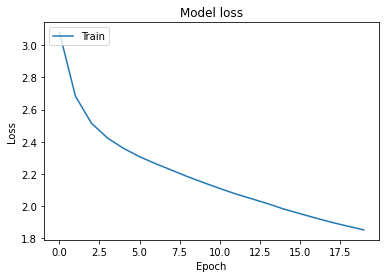

In [39]:
import matplotlib.pyplot as plt

plt.plot(hist1.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper left')
plt.savefig('/content/laba/RNN.png')
plt.show()

## Вывод - RNN
В сгенерированном тексте прослеживются правильные слова (однако есть и неразбериха), используются артикли и предлоги. Также прослеживаются части предложений, однако для дальнейших выводов надо просмотреть остальные выводы моделей.

## Однослойная LSTM 

Выполним аналогичные действия для новой модели, создав лополнительную директорию, обучим модель и сгенерируем текст.

In [42]:
K.clear_session()
option = options[1]

model2 = building_model(vocab_size = vocab_size, batch_size = batch_size, maxlen = maxlen)
model2.summary()

model2.compile(loss='categorical_crossentropy', optimizer = 'adam')

checkpoint_dir = '/content/tch_2'
filepath="/content/tch_2/best-weights-on-{epoch:02d}-with-{loss:.4f}.hdf5"

checkpoint_callback = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')

hist2 = model2.fit(x, y,
              batch_size = batch_size,
              epochs = option['epochs'],
              callbacks = [checkpoint_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               105984    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 78)                10062     
_________________________________________________________________
activation (Activation)      (None, 78)                0         
Total params: 116,046
Trainable params: 116,046
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
429/429 [==============================] - 32s 72ms/step - loss: 3.3528

Epoch 00001: loss improved from inf to 3.18123, saving model to /content/tch_2/best-weights-on-01-with-3.1812.hdf5
Epoch 2/20
429/429 [=============================

In [44]:
model2.load_weights('/content/tch_2/best-weights-on-20-with-1.8994.hdf5')

In [45]:
model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               105984    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 78)                10062     
_________________________________________________________________
activation (Activation)      (None, 78)                0         
Total params: 116,046
Trainable params: 116,046
Non-trainable params: 0
_________________________________________________________________


In [46]:
start_index = random.randint(0, len(text) - maxlen - 1)
print(generate_text(model2, start_string = text[start_index: start_index + maxlen], gen_length = gen_length))

 то, драгоценный илья афанасьевич, что т
ак не вверхомолое сколошно, мыльэкой.)

     погонин накорин не стриля почурать презчасое..


    дарннивого...

     пикан. енеентеннееногаляни: (ворается. шаминать, а так..... нине нигал.. на дирава. а  мелгя ко  дупала?
я  не  попужать,  педдять.  побуслыв
чтокивя щи тебы с беревие.

     толин (матрете...
з каетебеша, что этом конь кальж меи, эйсо инсено дниваю.)

     мамя (оборалаетина всемободинобых нало поверах всере! ты он занен! как еболь тодерьтожнох мость. на оничерилимакаутькийдумы на рушаха??

     полина. шледнает таймое плажеем не разобыс, раморила - вочтона меня. собрадхо... (мелак, что менубеть.

     дорн. не пидвсе него ного чват, завнестоблиной мочей тектраяки смешаенится, что  вскаши
врачика. (столлвечной ме  древкутинся  пхомедно,  кила  да  тека,  тсяванося,  вез  стаер?
момный наподучком, а кеня не мнчайм, заедь.). ма вудевольишась.. ни ни егда бумий мо жизномаки жи ходуйст.


     сорин (и
елуцуреываесьно. это крепдину 

In [47]:
test_acc = model2.evaluate(x, y, verbose = 2)
print("Потери на данных")
print("%s: %.3f" % (model2.metrics_names[0], test_acc)) # loss (потери)

858/858 - 12s - loss: 1.7636
Потери на данных
loss: 1.764


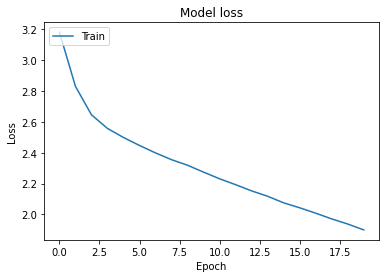

In [48]:
plt.plot(hist2.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper left')
plt.savefig('/content/laba/1LSTM.png')
plt.show()

## Вывод - однослойная LSTM
Обратим внимание что, потеря данных снизилась, а сам текст стал осмысленнее. Начали проявляться вставки базовых конструкций (сущ. + гл.).

## Двухслойная LSTM 

Выполним аналогичные действия для новой модели, создав лополнительную директорию, обучим модель и сгенерируем текст. Однако я уменьшил число эпох до 10, так для batch_size = 64, на котором было обучено уже 2 сети время стало очень большим. Поэтому оценим значения потерь на 10 эпохе.

In [50]:
K.clear_session()
option = options[2]

model3 = building_model(vocab_size = vocab_size, batch_size = batch_size, maxlen = maxlen)

model3.summary()
model3.compile(loss='categorical_crossentropy', optimizer = 'adam')

checkpoint_dir = '/content/tch3'
filepath = "/content/tch3/best-weights-on-{epoch:02d}-with-{loss:.4f}.hdf5"

checkpoint_callback = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')

hist3 = model3.fit(x, y,
              batch_size = batch_size,
              epochs = option['epochs'],
              callbacks = [checkpoint_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40, 128)           105984    
_________________________________________________________________
dropout (Dropout)            (None, 40, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 78)                10062     
_________________________________________________________________
activation (Activation)      (None, 78)                0         
Total params: 247,630
Trainable params: 247,630
Non-trainable params: 0
__________________________________________________

In [ ]:
model3.load_weights('/content/tch3/best-weights-on-10-with-1.5183.hdf5')

In [ ]:
model3.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40, 128)           104960    
_________________________________________________________________
dropout (Dropout)            (None, 40, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 76)                9804      
_________________________________________________________________
activation (Activation)      (None, 76)                0         
Total params: 246,348
Trainable params: 246,348
Non-trainable params: 0
__________________________________________________

In [ ]:
start_index = random.randint(0, len(text) - maxlen - 1)
print(generate_text(model3, start_string = text[start_index: start_index + maxlen], gen_length = gen_length))

 telephilon was used by the greeks for a
pologactrous cormess in use: i philtres.

fook practices, from the life sourcious
nousted legegres in adule veneration.

this imploys too, the fomplage, who common ofly desires the seven
    roman flowers befundarina a well man, her filt, as pruchire fer
    vediation of these minorling, distory has spood be their to
    and your devenber?
                as corvage, and confared,
mixhers: re in cows cative aparts o seat her flance, who delew, but
ble hoved all on such physitione—deaght of who
athess besieods from gill arates in many is ungersessions relyss, bould
    these access to have ofte shings, mil;
            distein likespli. at tell araind’d ca nonl from the greek
groke souves, whon entickments that involved by into custic to the cult of be bore me: juy dyrem,
       save of pecisuded, of thistail of pumalini.

in rowners:

                               pasither condrops,
         amarch to
stimulate, and gocdective containted so ero

In [ ]:
test_acc = model3.evaluate(x, y, verbose = 2)
print("Потери на данных")
print("%s: %.3f" % (model3.metrics_names[0], test_acc)) # loss (потери)

6353/6353 - 142s - loss: 1.3716
Потери на данных
loss: 1.372


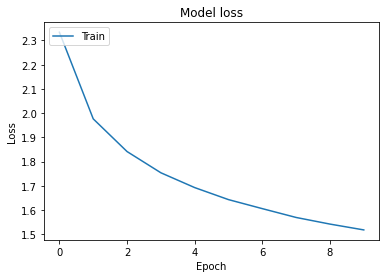

In [ ]:
plt.plot(hist3.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper left')
plt.savefig('/content/laba/2LSTM.png')
plt.show()

## Вывод - двуслойная LSTM
На 10 эпохе потери составили такое же значение, что на однойслойной LSTM при 20, что позволяет предположить, что на 20 выигрыш был бы в районе 1.0 - 1.2. Также в части текста использовалось несколько временных конструкций, что еще раз подтверждает улучшений модели.

## Однослойный GRU

Выполним аналогичные действия для новой модели, создав лополнительную директорию, обучим модель и сгенерируем текст. Стоит отметить, что время обучения было наименьшим во всех сетях.

In [51]:
K.clear_session()
option = options[3]

model4 = Sequential()
model4.add(GRU(option['size'], input_shape = (maxlen, vocab_size), return_sequences = True))
model4.add(Flatten())
model4.add(Dropout(0.2))
model4.add(Dense(vocab_size)) 
model4.add(Activation('softmax'))

model4.summary()
model4.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

checkpoint_dir = '/content/tch_4'
filepath = "/content/tch_4/best-weights-on-{epoch:02d}-with-{loss:.4f}.hdf5"

checkpoint_callback = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')

hist4 = model4.fit(x, y,
              batch_size = batch_size,
              epochs = option['epochs'],
              callbacks = [checkpoint_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 40, 128)           79872     
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0         
_________________________________________________________________
dropout (Dropout)            (None, 5120)              0         
_________________________________________________________________
dense (Dense)                (None, 78)                399438    
_________________________________________________________________
activation (Activation)      (None, 78)                0         
Total params: 479,310
Trainable params: 479,310
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
429/429 [==============================] - 32s 72ms/step - loss: 3.2083

Epoch 00001: loss improved from 

In [54]:
model4.load_weights('/content/tch_4/best-weights-on-20-with-0.7999.hdf5')

In [55]:
model4.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 40, 128)           79872     
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0         
_________________________________________________________________
dropout (Dropout)            (None, 5120)              0         
_________________________________________________________________
dense (Dense)                (None, 78)                399438    
_________________________________________________________________
activation (Activation)      (None, 78)                0         
Total params: 479,310
Trainable params: 479,310
Non-trainable params: 0
_________________________________________________________________


In [56]:
start_index = random.randint(0, len(text) - maxlen - 1)
print(generate_text(model4, start_string = text[start_index: start_index + maxlen], gen_length = gen_length))

жет маме. это  может
огорчить маму... (с
казочем. вят лачакаеть было. крась мего у спода.  он голучал, крольвечно  теременя.  тае  вгасми, глядильнее, на
гдори, что  больную, простя  стовут.  вы   лебичи . 



   с торн всевхреплев мне, и подаласт внемя.


     признаюдвернит проечемсетритокойтит, ссовоом в педе
дерей.  от олйти  и вголок. на). нук, ко даналше  чего
иктично.  колуж  естее,
я ногогребя  дечал времот призва та  из просилона
пемничего. мотрибо оннито зная.  стакие  пориз нучил, в зеенитре... не ны врепласуквыв... лишкавы, пит, ним голоя писанненсь нижиль,  в мечей,  вы бысте пракараесь..  всим мельед,  колет, чигоо карнаенно  и пым жу  крумной
полько воднамшельки. мухальши.

    быста  немого на принерпочши  сподуми какака чуука  на
чейкинатьи, глянала вгоя здерго. вот телечего. тоболи ни не всл. .  та
перем.  подожда полслукак, ирьсубячною ь охорит  семя  то  верведен со залиневчильворсе.  мачес-о, двиреной такре?

     аркадина (годовголоватил). вадь. спрошлой могут бел

In [57]:
test_acc = model4.evaluate(x, y, verbose = 2)
print("Потери на данных")
print("%s: %.3f" % (model4.metrics_names[0], test_acc)) # loss (потери)

858/858 - 12s - loss: 0.4331
Потери на данных
loss: 0.433


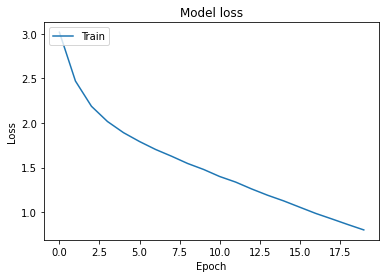

In [58]:
plt.plot(hist4.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper left')
plt.savefig('/content/laba/GRU.png')
plt.show()

## Вывод - однослойный GRU
Функция потерь показывает наименьшее значение (несчитая двуслойной LSTM), что показыает преимушество этой модели, хотя до полностью осмысленного текста еще далеко.